<a href="https://colab.research.google.com/github/valeriu-balaban/fair-ml-presentation/blob/main/Fair_ML_Presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Fair ML Models

 - Fairness will play a major role in automated systems such as ML
 - For now we do not always have many answers, just a lot of questions
 - Let's make it interactive. Think and answer questions 
 - There is no right of wrong answer
 - Presented methods can be easily integrated in any project
 - Code is in vanila Pytorch and can be ported to Keras, Tensorflow, JAX, etc.

**Outline:**
1. When things go wrong, examples
1. Datasets description, what a fair model should do.
1. Subgroup, individual fairness
1. Definition and fairness metrics
1. Conditional Value at Risk method
1. Wasserstein distance (maybe)
1. Variance penalization and reference group

## 1. Problem with $``the\ algorithm"$ 


  - Tiktok's algorithm prioritizes white people:
    ![tiktok](https://raw.githubusercontent.com/valeriu-balaban/fair-ml-presentation/main/Screenshot%202021-07-19%20at%2011-31-32%20tiktok%20race%20problem%20at%20DuckDuckGo.png)

  - Youtube's algorithm has other issues ([source](https://www.wsj.com/articles/youtubes-search-algorithm-directs-viewers-to-false-and-sexualized-videos-study-finds-11625644803)):
  ![youtube](https://raw.githubusercontent.com/valeriu-balaban/fair-ml-presentation/main/Screenshot%202021-07-19%20at%2011-30-24%20YouTube%E2%80%99s%20Search%20Algorithm%20Directs%20Viewers%20to%20False%20and%20Sexualized%20Videos%2C%20Study%20Finds.png)

  - Facebook's algorithm has ome other problems ([source](https://www.technologyreview.com/2019/04/05/1175/facebook-algorithm-discriminates-ai-bias/)):
  ![facebook](https://raw.githubusercontent.com/valeriu-balaban/fair-ml-presentation/main/Screenshot%202021-07-19%20at%2011-35-14%20Facebook%E2%80%99s%20ad-serving%20algorithm%20discriminates%20by%20gender%20and%20race.png)

  - And the same problem can be posed for self-driving cars ([source](https://www.technologyreview.com/2018/10/24/139313/a-global-ethics-study-aims-to-help-ai-solve-the-self-driving-trolley-problem/))
  ![self-driving-cars](https://raw.githubusercontent.com/valeriu-balaban/fair-ml-presentation/main/Screenshot%202021-07-19%20at%2012-01-08%20Should%20a%20self-driving%20car%20kill%20the%20baby%20or%20the%20grandma%20Depends%20on%20where%20you%E2%80%99re%20from%20.png)

  - Evaluating the danger of an offender during (pre)trial ([source](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm))
    ![propublica](https://static.propublica.org/projects/algorithmic-bias/assets/img/generated/methodology-risk-of-recidivism-scores-by-race-900*363-482d1c.png)



None of these companies designed the ML algorithm to be biased. Yet it ended up biased on multiple occasions. 

**Why?**

### Answer

*Learning from data without suppervision can (usually does) lead to issues because humans that generate the data discriminate by race, skin color, gender, age, etc.*

https://www.youtube.com/embed/NaWJhlDb6sE



In [2]:
import torch

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [4]:
def generate_toy_data(n_samples, n_samples_low, n_dimensions, seed=0):
  """
  Dataset generation code from Michele Donini, et al. "Empirical Risk
  Minimization under Fairness Constraints. https://github.com/jmikko/fair_ERM
  """
  np.random.seed(seed)
  varA = 0.8
  aveApos = [-1.0] * n_dimensions
  aveAneg = [1.0] * n_dimensions
  varB = 0.5
  aveBpos = [0.5] * int(n_dimensions / 2) + [-0.5] * int(n_dimensions / 2 + n_dimensions % 2)
  aveBneg = [0.5] * n_dimensions
  X = np.random.multivariate_normal(aveApos, np.diag([varA] * n_dimensions), n_samples)
  X = np.vstack([X, np.random.multivariate_normal(aveAneg, np.diag([varA] * n_dimensions), n_samples)])
  X = np.vstack([X, np.random.multivariate_normal(aveBpos, np.diag([varB] * n_dimensions), n_samples_low)])
  X = np.vstack([X, np.random.multivariate_normal(aveBneg, np.diag([varB] * n_dimensions), n_samples)])
  sensible_feature = [1] * (n_samples * 2) + [-1] * (n_samples + n_samples_low)
  sensible_feature = np.array(sensible_feature)
  sensible_feature.shape = (len(sensible_feature), 1)
  X = np.hstack([X, sensible_feature])
  y = [1] * n_samples + [-1] * n_samples + [1] * n_samples_low + [-1] * n_samples
  y = np.array(y)
  sensible_feature_id = len(X[1, :]) - 1
  idx_A = list(range(0, n_samples * 2))
  idx_B = list(range(n_samples * 2, n_samples * 3 + n_samples_low))

  return X, y, sensible_feature_id, idx_A, idx_B

In [17]:
# data parameters
n_samples = 100
n_samples_low = 20
# Prepare the dataset
X, y, _,_,_ = generate_toy_data(n_samples, n_samples_low, n_dimensions=2, seed=0)

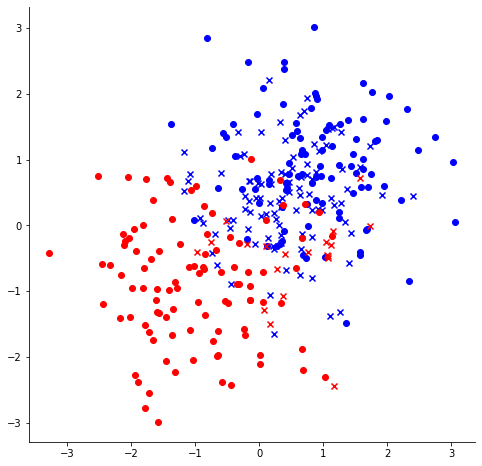

In [34]:
s1 = (X[:, 2] < 0)
s2 = (X[:, 2] > 0)

c1s1 = (y[s1] == -1)
c1s2 = (y[s2] == -1)
c2s1 = (y[s1] ==  1)
c2s2 = (y[s2] ==  1)


plt.figure(figsize=(8, 8))

plt.scatter(X[s1, 0][c1s1], X[s1, 1][c1s1], marker='x', color='b')
plt.scatter(X[s2, 0][c1s2], X[s2, 1][c1s2], marker='o', color='b')

plt.scatter(X[s1, 0][c2s1], X[s1, 1][c2s1], marker='x', color='r')
plt.scatter(X[s2, 0][c2s2], X[s2, 1][c2s2], marker='o', color='r')
# plt.plot(X[s2, 0], X[s2, 1], '.')

sns.despine()

In [24]:
y[200], y[199], y.shape

(1, -1, (320,))

## Definition and fainess metrics


### Notation:

To simplify things we will focus only on classification. Although, the methods work for both, regression and classification.


- $X$ - input ($x$ one input sample)
- $Y$ - labels ($y$ one label sample)
- $S$ - sensitive attributes which are part of X (e.g., gender, age, race)
- $f$ - model we train, i.e., $f(x; \theta)$ returns the probability of each labels
- $\theta$ - model parameters, e.g., the weights and the biases for NN
- $\ell$ - loss function, here we will always use cross-entropy ($-log f(x; \theta) [y]$)
- $\mathbb{E}[\ell(f, X, Y)]$ - loss value, i.e., average loss
- $\min\mathbb{E}[\ell(f, X, Y)]$ - optimization objective

### Definitions of perfect fairness



- *Demografic parity:* $S \perp f(X; \theta)$
- *Equaized odds:* $S \perp f(X; \theta) \mid Y$
- *Lack of disparate mistreatment:* $\mathbb{P}(f(X; \theta) \neq Y \mid S = s_a) = \mathbb{P}(f(X; \theta) \neq Y \mid S = s_b) , \forall s_a, s_b \in S$

**Questions:**
1. What is the difference between the first two from the perspective of application?
1. What is the problem with these definitions?

### Approximate fairness

- *Mean difference score:* $\max \mid \mathbb{P}(f(X; \theta) = y \mid S = s_a) - \mathbb{P}(f(X; \theta) = y \mid S = s_b) \mid, \forall s_a, s_b \in S, \forall y \in Y$

- *Covariance:* $\mathbb{E}[f(X; \theta) \cdot S] - \mathbb{E}[f(X; \theta)] \cdot \mathbb{E}[S]$

**Questions:**
1. Why these two metrics are approximate
1. Why we use the approximate metrics instead of perfect metrics of fairness?

[Correlation Wikipedia](https://en.wikipedia.org/wiki/Correlation)